## Imports

In [1]:
import numpy as np
import pandas as pd
import talib as ta
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## Data

In [2]:
# Gets the data of the prices of stock for a specific company
# Adds Movement info based on closing price
# If price does not change we keep movement as up for simplicity sake

path = '../processeddata/individual_stocks_5yr/individual_stocks_5yr/'
ticker = 'T' # Change Stock to analyze

p = path + ticker + '_data.csv' 
df = pd.read_csv(p)
df.set_index(['date'],inplace=True)

df['Movement'] = 'Up'

prevPrice = 0.0
for index, row in df.iterrows():
    if row['close'] < prevPrice:
        df.loc[index, 'Movement'] = 'Down'
    prevPrice = row['close']

print(df)

             open    high     low  close    volume Name Movement
date                                                            
2013-02-08  35.39  35.525  35.160  35.27  18275496    T       Up
2013-02-11  35.26  35.315  35.060  35.23  13687717    T     Down
2013-02-12  35.25  35.670  35.230  35.60  16958584    T       Up
2013-02-13  35.67  35.810  35.340  35.42  17410587    T     Down
2013-02-14  35.42  35.440  35.030  35.29  26205412    T     Down
...           ...     ...     ...    ...       ...  ...      ...
2018-02-01  38.51  39.290  38.401  39.16  59963826    T       Up
2018-02-02  39.03  39.040  37.810  38.07  46098657    T     Down
2018-02-05  37.81  38.310  36.630  36.63  45595537    T     Down
2018-02-06  36.08  37.070  35.500  36.83  62905300    T       Up
2018-02-07  36.81  37.450  36.740  36.93  35634519    T       Up

[1259 rows x 7 columns]


# DECISION TREE

In [3]:
# Setting Technical Indicators
# Momentum: Relative Strength Index (RSI) 
# Trend: Moving Average Convergence Divergence (MACD), Estimated Moving Average (EMA)
# Volatility: Average True Range (ATR) 

df['RSI'] = ta.RSI(df['close'].values, timeperiod=14)
df['EMA26'] = ta.EMA(df['close'].values, timeperiod = 26)
df['EMA12'] = ta.EMA(df['close'].values, timeperiod = 12)

macdLine, signalLine, macdhist = ta.MACD(df['close'].values, fastperiod=12, slowperiod=26, signalperiod=9)

df['MACDLine'] = macdLine
df['SignalLine'] = signalLine

df['ATR'] = ta.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)

df['CloseEMA12'] = np.where(df['close'] > df['EMA12'], 1, -1)
# Adding signals for EMA and MACD
df['EMASignal'] = np.where(df['EMA12'] > df['EMA26'], 1, -1)
df['MACDSignal'] = np.where(df['SignalLine'] > df['MACDLine'], 1, -1)

# Zero Line Crossover
macdAbove0 = False
for index, row in df.iterrows():
    if np.isnan(row['MACDLine']):
        pass
    else:
        if row['MACDLine'] > 0:
            if macdAbove0 == False:
                df.loc[index, 'MACDSignal'] = 1
                macdAbove0 = True    
        else:
            if macdAbove0 == True:
                df.loc[index, 'MACDSignal'] = -1
                macdAbove0 = False


# Signal Line Crossover 

# If MACD crosses signal upward, bullish (1), Else bearish (-1)
# If Does not cross, skip. Use zero line crossover
macdAbove = False
for index, row in df.iterrows():
    if np.isnan(row['MACDLine']) or np.isnan(row['SignalLine']):
        pass
    else:
        if row['MACDLine'] > row['SignalLine']:
            if macdAbove == False:
                df.loc[index, 'MACDSignal'] = 1
                macdAbove = True    
        else:
            if macdAbove == True:
                df.loc[index, 'MACDSignal'] = -1
                macdAbove = False

df = df.dropna()

df


,open,high,low,close,volume,Name,Movement,RSI,EMA26,EMA12,MACDLine,SignalLine,ATR,CloseEMA12,EMASignal,MACDSignal
date,,,,,,,,,,,,,,,,
2013-03-28,36.69,36.83,36.500,36.69,37398731,T,Up,60.578269,36.176625,36.461389,0.311194,0.372985,0.380676,1,1,1
2013-04-01,36.71,37.32,36.710,37.25,24210093,T,Up,68.180864,36.256135,36.582714,0.348943,0.368176,0.398485,1,1,1
2013-04-02,37.48,37.69,37.320,37.57,26226670,T,Up,71.556501,36.353458,36.734604,0.400069,0.374555,0.401451,1,1,1
2013-04-03,37.51,37.60,37.210,37.28,24289883,T,Down,64.842802,36.422091,36.818511,0.412432,0.382131,0.400633,1,1,-1
2013-04-04,37.35,37.96,37.320,37.91,72852651,T,Up,71.170875,36.532306,36.986432,0.467675,0.399239,0.420587,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,38.51,39.29,38.401,39.16,59963826,T,Up,64.396040,37.526672,37.670719,0.144047,0.042081,0.725184,1,1,1
2018-02-02,39.03,39.04,37.810,38.07,46098657,T,Down,54.079081,37.566918,37.732147,0.165228,0.066710,0.769814,1,1,-1
2018-02-05,37.81,38.31,36.630,36.63,45595537,T,Down,44.040629,37.497517,37.562586,0.065069,0.066382,0.834827,-1,1,-1


In [4]:
# Prediction
p = df[['RSI', 'ATR', 'CloseEMA12', 'EMASignal', 'MACDSignal']]
X = p

y = df[['Movement']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [5]:
# Show confusion matrix
def plot_confusion_matrix(confusion_mat, cln):
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.gray)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(cln)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Gini Tree

[[ 71 104]
 [ 31 162]]


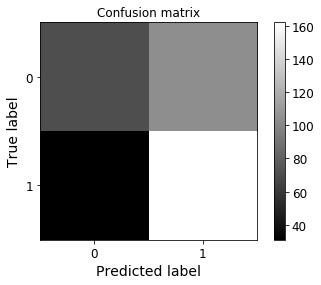

              precision    recall  f1-score   support

        Down       0.70      0.41      0.51       175
          Up       0.61      0.84      0.71       193

    accuracy                           0.63       368
   macro avg       0.65      0.62      0.61       368
weighted avg       0.65      0.63      0.61       368



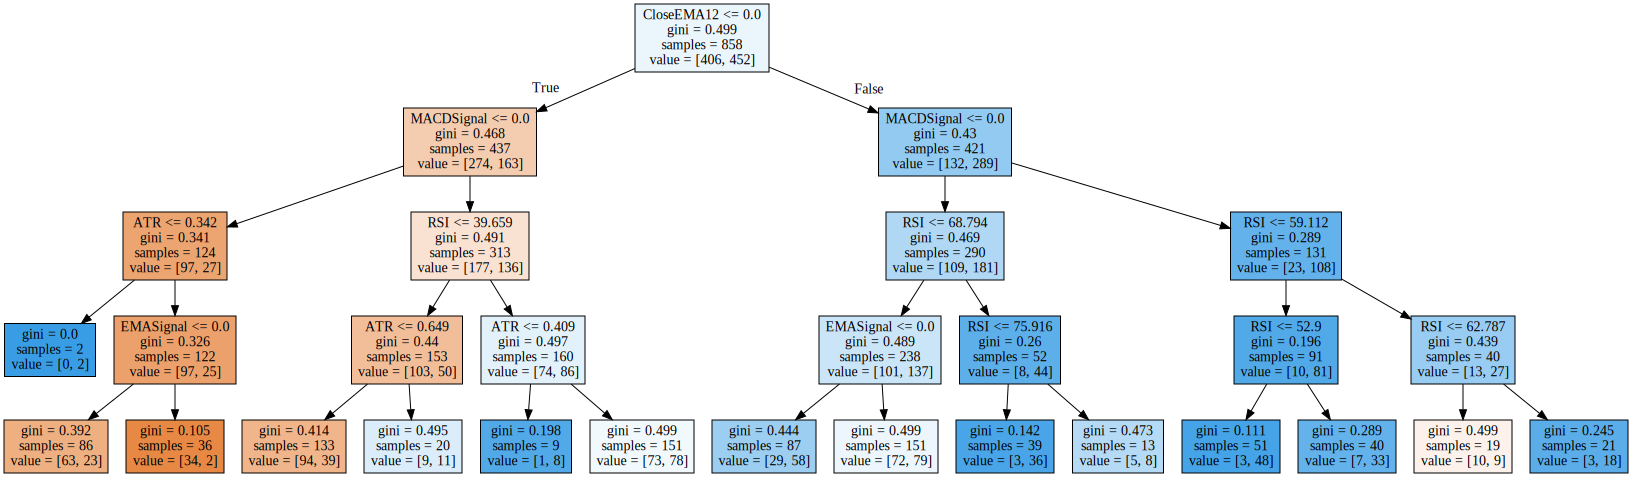

In [6]:
# Training
clf = DecisionTreeClassifier(max_depth=4, criterion="gini", random_state = 42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm, 2)

# Print classification report
result_metrics = classification_report(y_test, y_pred)
print(result_metrics)

# Tree
dot_data = tree.export_graphviz(clf, out_file=None, filled=True,
                                feature_names=['RSI', 'ATR', 'CloseEMA12', 'EMASignal', 'MACDSignal'])
graphviz.Source(dot_data)



Accuracy =  0.7042931162102147


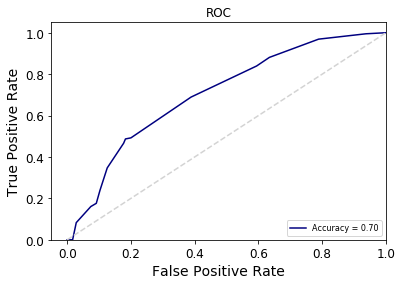

In [7]:
from sklearn.metrics import roc_curve, auc

test = []

for index, row in y_test.iterrows():
    if row['Movement'] == 'Up':
        test.append(1)
    else:
        test.append(0)

y_score = clf.predict_proba(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(test, y_score[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)
print('Accuracy = ', roc_auc)

count = 1

# Get different color each graph line
colorSet = ['navy', 'greenyellow', 'deepskyblue', 'darkviolet', 'crimson', 
            'darkslategray', 'indigo', 'brown', 'orange', 'palevioletred', 'mediumseagreen',
            'k', 'darkgoldenrod', 'g', 'midnightblue', 'c', 'y', 'r', 'b', 'm', 'lawngreen'
            'mediumturquoise', 'lime', 'teal', 'drive', 'sienna', 'sandybrown']
color = colorSet[count-1]

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, c=color, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Entropy Tree

[[ 65 110]
 [ 23 170]]


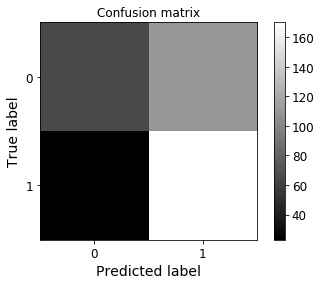

              precision    recall  f1-score   support

        Down       0.74      0.37      0.49       175
          Up       0.61      0.88      0.72       193

    accuracy                           0.64       368
   macro avg       0.67      0.63      0.61       368
weighted avg       0.67      0.64      0.61       368



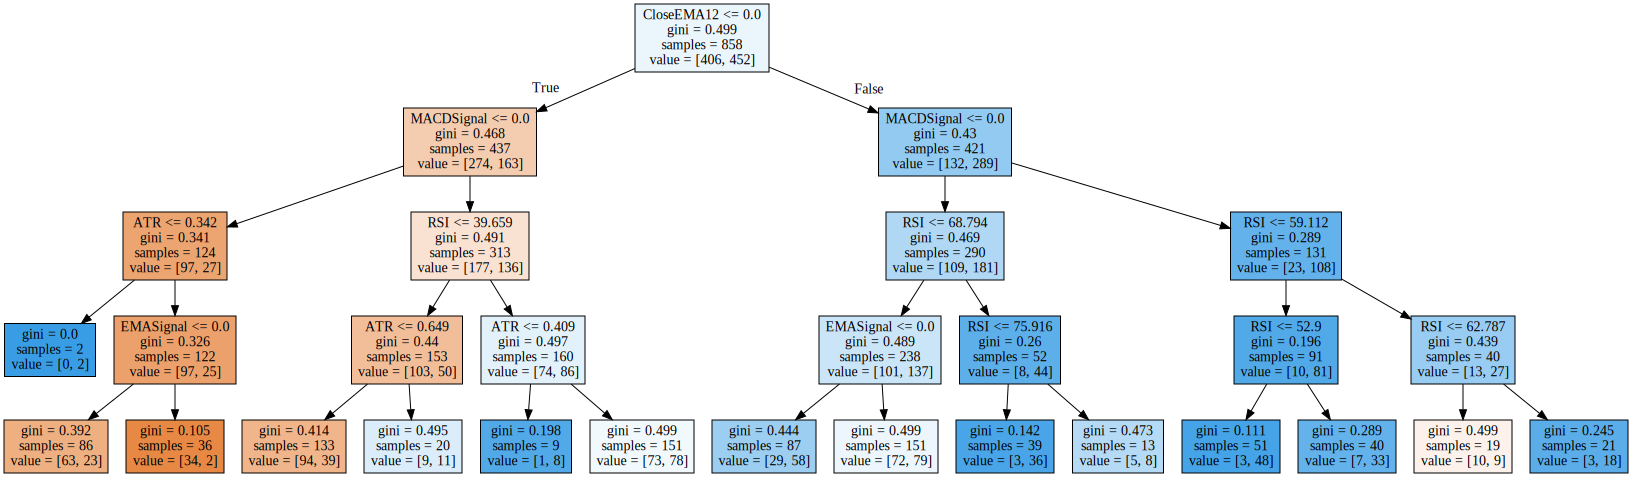

In [8]:
# Training
clfEntro = DecisionTreeClassifier(max_depth=4, criterion="entropy" , random_state = 42)
clfEntro.fit(X_train, y_train)

# Evaluation
y_pred = clfEntro.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm, 2)

# Print classification report
result_metrics = classification_report(y_test, y_pred)
print(result_metrics)

# Tree
dot_data = tree.export_graphviz(clf, out_file=None, filled=True,
                                feature_names=['RSI', 'ATR', 'CloseEMA12', 'EMASignal', 'MACDSignal'])
graphviz.Source(dot_data)

Accuracy =  0.6951295336787564


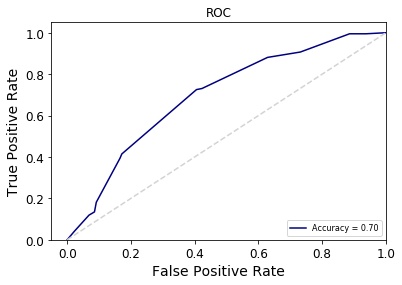

In [9]:
test = []

for index, row in y_test.iterrows():
    if row['Movement'] == 'Up':
        test.append(1)
    else:
        test.append(0)

y_score = clfEntro.predict_proba(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(test, y_score[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)
print('Accuracy = ', roc_auc)

count = 1

# Get different color each graph line
colorSet = ['navy', 'greenyellow', 'deepskyblue', 'darkviolet', 'crimson', 
            'darkslategray', 'indigo', 'brown', 'orange', 'palevioletred', 'mediumseagreen',
            'k', 'darkgoldenrod', 'g', 'midnightblue', 'c', 'y', 'r', 'b', 'm', 'lawngreen'
            'mediumturquoise', 'lime', 'teal', 'drive', 'sienna', 'sandybrown']
color = colorSet[count-1]

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, c=color, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# K-NEAREST-NEIGHBOURS

[[104  71]
 [ 56 137]]


C:\Users\cfong\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


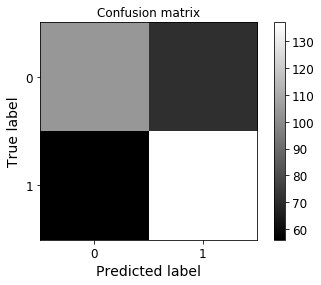

              precision    recall  f1-score   support

        Down       0.65      0.59      0.62       175
          Up       0.66      0.71      0.68       193

    accuracy                           0.65       368
   macro avg       0.65      0.65      0.65       368
weighted avg       0.65      0.65      0.65       368



In [10]:
clfknn = KNeighborsClassifier(n_neighbors=3)
clfknn.fit(X_train, y_train)
clfknn.score(X_test, y_test)

y_pred = clfknn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm, 2)

# Print classification report
result_metrics = classification_report(y_test, y_pred)
print(result_metrics)

Accuracy =  0.6775425610658772


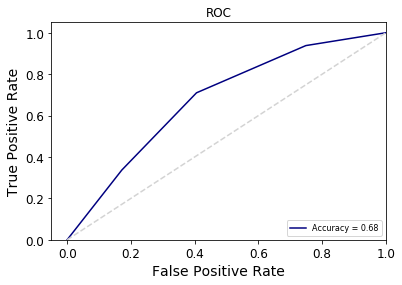

In [11]:
test = []

for index, row in y_test.iterrows():
    if row['Movement'] == 'Up':
        test.append(1)
    else:
        test.append(0)

y_score = clfknn.predict_proba(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(test, y_score[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)
print('Accuracy = ', roc_auc)

count = 1

# Get different color each graph line
colorSet = ['navy', 'greenyellow', 'deepskyblue', 'darkviolet', 'crimson', 
            'darkslategray', 'indigo', 'brown', 'orange', 'palevioletred', 'mediumseagreen',
            'k', 'darkgoldenrod', 'g', 'midnightblue', 'c', 'y', 'r', 'b', 'm', 'lawngreen'
            'mediumturquoise', 'lime', 'teal', 'drive', 'sienna', 'sandybrown']
color = colorSet[count-1]

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, c=color, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()